# Brain Stroke Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import missingno as msno
import autoreload
import warnings 
import os
import sys
import csv

from collections import defaultdict, Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, recall_score, precision_score

%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

sb.set()
sb.set_style('ticks')

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"D:\Open Classroom\Datasets\Brain Stroke Dataset\brain_stroke.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [3]:
df.shape

(4981, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [5]:
round(df.describe())

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.0,4981.0,4981.0,4981.0,4981.0,4981.0
mean,43.0,0.0,0.0,106.0,28.0,0.0
std,23.0,0.0,0.0,45.0,7.0,0.0
min,0.0,0.0,0.0,55.0,14.0,0.0
25%,25.0,0.0,0.0,77.0,24.0,0.0
50%,45.0,0.0,0.0,92.0,28.0,0.0
75%,61.0,0.0,0.0,114.0,33.0,0.0
max,82.0,1.0,1.0,272.0,49.0,1.0


In [6]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [8]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [9]:
sb.countplot(df['gender'], hue = df['stroke'])

ValueError: Cannot use `hue` without `x` and `y`

<Axes: xlabel='age', ylabel='Density'>

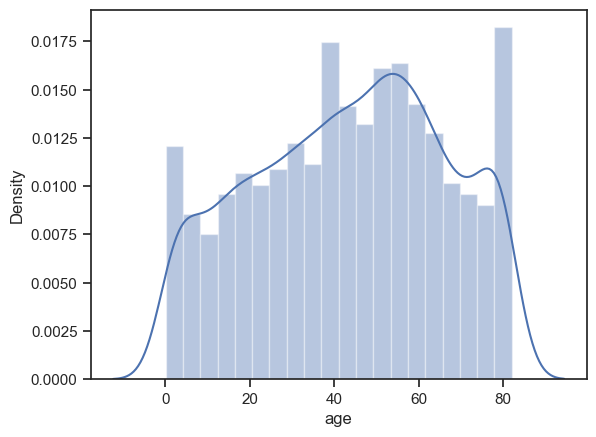

In [10]:
sb.distplot(df['age'])

<Axes: xlabel='avg_glucose_level', ylabel='Density'>

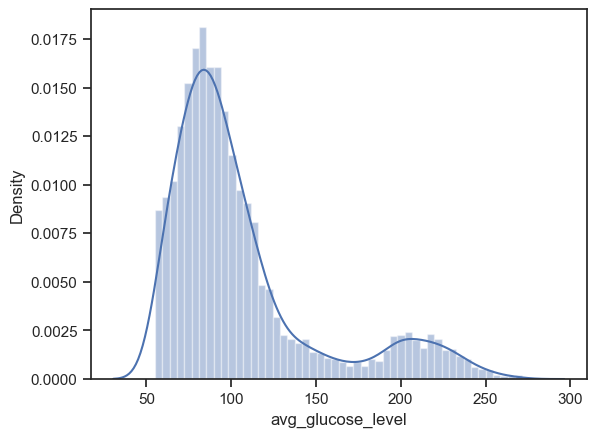

In [11]:
sb.distplot(df['avg_glucose_level'])

<Axes: xlabel='bmi', ylabel='Density'>

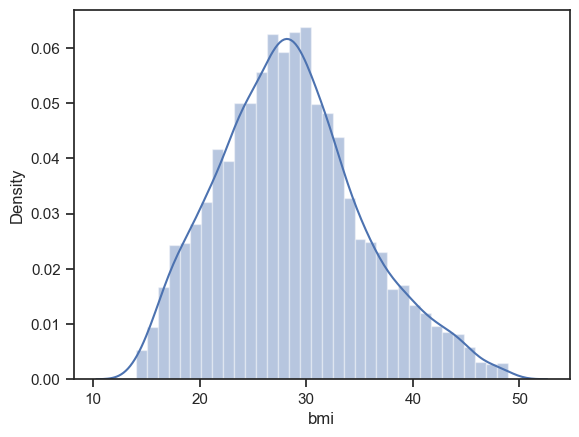

In [12]:
sb.distplot(df['bmi'])

In [13]:
sb.countplot(df['smoking_status'], hue = df['gender'])

ValueError: Cannot use `hue` without `x` and `y`

### Feature Engineering

In [14]:
le = LabelEncoder()

def transform_categorical(data):
    categories = (data.dtypes == 'object')
    cat_cols = list(categories[categories].index)
    le = LabelEncoder()
    for col in cat_cols:
        data[col] = le.fit_transform(data[col])

In [15]:
transform_categorical(df)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,1,1,228.69,36.6,1,1
1,1,80.0,0,1,1,1,0,105.92,32.5,2,1
2,0,49.0,0,0,1,1,1,171.23,34.4,3,1
3,0,79.0,1,0,1,2,0,174.12,24.0,2,1
4,1,81.0,0,0,1,1,1,186.21,29.0,1,1


In [16]:
x = df.drop(columns = 'stroke')
y = df['stroke']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=40)

print('x train', x_train.shape)
print('x test', x_test.shape)
print('y train', y_train.shape)
print('y test', y_test.shape)

x train (3984, 10)
x test (997, 10)
y train (3984,)
y test (997,)


#### Model Evaluation

In [21]:
def run_experiment(model):
    
    model.fit(x_train, y_train)
    
    pred = model.predict(x_test)
    
    #ConfusionMatrixDisplay(model, x_test, y_test)
    plt.title('Confusion Matrix for ' + str(model))
    plt.show()
    
    print(f'Precision {precision_score(y_test, pred)}')
    print(f'F1 Score {f1_score(y_test, pred)}')
    print(f'Recall {recall_score(y_test, pred)}')
    print(f'Accuracy {accuracy_score(y_test, pred)}')

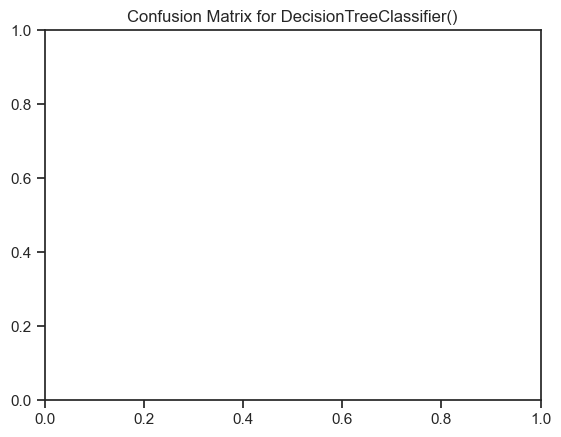

Precision 0.07692307692307693
F1 Score 0.08
Recall 0.08333333333333333
Accuracy 0.9077231695085256


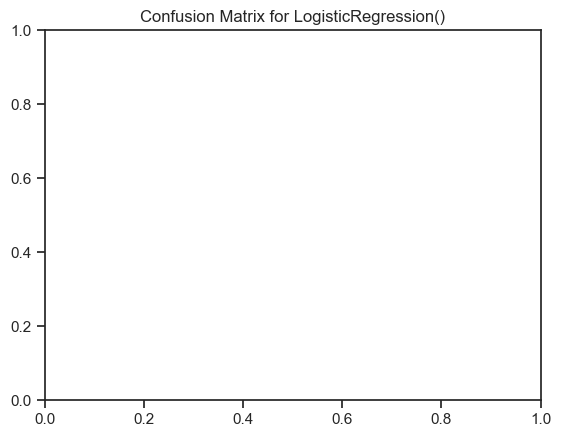

Precision 0.0
F1 Score 0.0
Recall 0.0
Accuracy 0.950852557673019


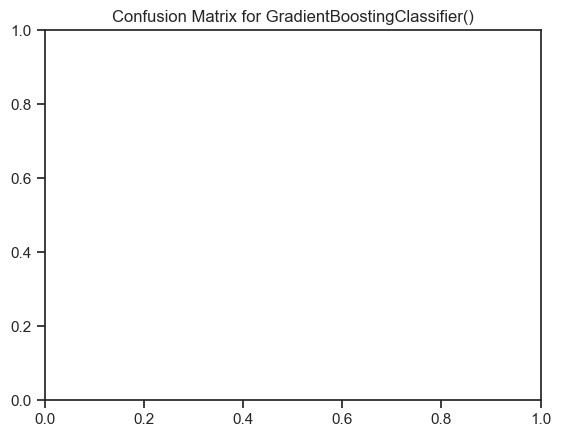

Precision 0.0
F1 Score 0.0
Recall 0.0
Accuracy 0.9498495486459378


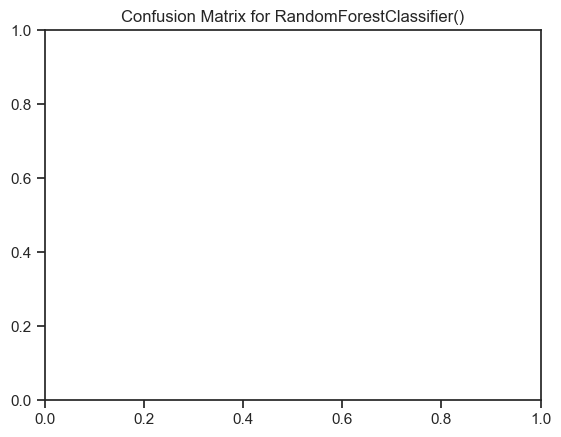

Precision 0.0
F1 Score 0.0
Recall 0.0
Accuracy 0.9498495486459378


In [22]:

dtc = DecisionTreeClassifier()
lr = LogisticRegression()
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier()

models = {
    dtc:DecisionTreeClassifier(),
    lr:LogisticRegression(),
    gbc:GradientBoostingClassifier(),
    rfc:RandomForestClassifier()
          }

for i in models.keys():
    run_experiment(i)



#### Manual Testing

In [23]:
def Manual_Testing(model, data):
    input_data = data
    
    input_data_to_array = np.asarray(input_data)
    
    reshape_input_data = input_data_to_array.reshape(1, -1)
    
    model.fit(x_train, y_train)
    
    pred = model.predict(reshape_input_data)
    
    if pred == 0:
        print('Presence of stroke not detected')
    else:
        print('Stroke detected')

In [38]:
data = (0, 73.0, 1, 1, 0, 0, 0, 190.22, 9.5, 2)
Manual_Testing(rfc, data)

Presence of stroke not detected


In [25]:
df.sample(4).head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1744,1,54.0,0,1,1,0,1,222.46,35.7,2,0
84,0,77.0,0,0,1,0,0,190.32,31.4,2,1
2675,1,24.0,0,0,0,1,0,93.76,24.0,1,0
218,0,37.0,0,0,1,1,0,73.50,26.1,1,0


In [26]:
df['gender'].unique()

array([1, 0])